In [1]:
"""Modified by HE WEI Oct 27,2017"""
import numpy as np
from PIL import Image, ImageDraw, ImageFont
from skimage import transform as tf
import os

In [2]:
def create_captcha(text, shear=0, size=(100,26)):
    im = Image.new("L", size, "black")
    draw = ImageDraw.Draw(im)
    filename= os.path.join(os.path.abspath('Chapter 8'), "Coval-Black.otf")
    #print(filename)
    font = ImageFont.truetype(filename, 22)
    draw.text((0,0), text, fill=1, font=font)
    image = np.array(im)
    affine_tf = tf.AffineTransform(shear=shear)
    image = tf.warp(image, affine_tf)
    return image / image.max()

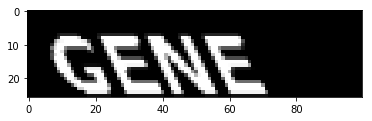

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
image = create_captcha("GENE", shear=0.5)
plt.imshow(image, cmap="gray")

In [4]:
from skimage.measure import label, regionprops

def segment_image(image):
    labeled_image = label(image > 0)
    subimages = []
    for region in regionprops(labeled_image):
        start_x, start_y, end_x, end_y = region.bbox
        subimages.append(image[start_x:end_x, start_y:end_y])
    if len(subimages) == 0:
        return [image,]
    return subimages

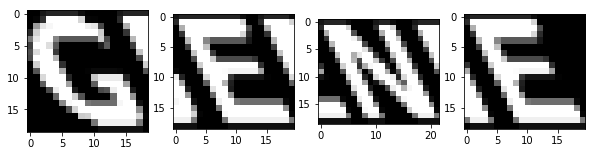

In [5]:
subimages = segment_image(image)
f, axes = plt.subplots(1, len(subimages), figsize=(10, 3))
for i in range(len(subimages)):
    axes[i].imshow(subimages[i], cmap="gray")

In [6]:
from sklearn.utils import check_random_state
random_state = check_random_state(14)
letters = list("ACBDEFGHIJKLMNOPQRSTUVWXYZ")
shear_values = np.arange(0, 0.5, 0.05)

In [7]:
def generate_sample(random_state=None):
    random_state = check_random_state(random_state)
    letter = random_state.choice(letters)
    shear = random_state.choice(shear_values)
    return create_captcha(letter, shear=shear, size=(20, 20)), letters.index(letter)

The target for this image is: 11


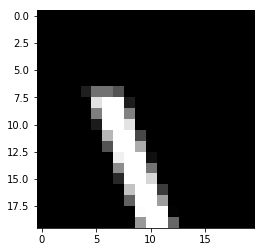

In [8]:
image, target = generate_sample(random_state)
plt.imshow(image, cmap="gray")
print("The target for this image is: {0}".format(target))

In [10]:
dataset, targets = zip(*(generate_sample(random_state) for i in
range(3000)))
dataset = np.array(dataset, dtype='float')
targets = np.array(targets)

In [11]:
from sklearn.preprocessing import OneHotEncoder
onehot = OneHotEncoder()
y = onehot.fit_transform(targets.reshape(targets.shape[0],1))

In [12]:
y = y.todense()

In [13]:
from skimage.transform import resize

In [14]:
dataset = np.array([resize(segment_image(sample)[0], (20, 20)) for
sample in dataset])

E:\Anaconda3\envs\DataMining\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [15]:
X = dataset.reshape((dataset.shape[0], dataset.shape[1] *
dataset.shape[2]))

In [16]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9)

print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(2700, 400) (2700, 26)
(300, 400) (300, 26)


E:\Anaconda3\envs\DataMining\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [17]:
from pybrain.datasets.supervised import SupervisedDataSet

In [18]:
training = SupervisedDataSet(X.shape[1], y.shape[1])
for i in range(X_train.shape[0]):
    training.addSample(X_train[i], y_train[i])

In [19]:
testing = SupervisedDataSet(X.shape[1], y.shape[1])
for i in range(X_test.shape[0]):
    testing.addSample(X_test[i], y_test[i])

In [20]:
from pybrain.tools.shortcuts import buildNetwork
net = buildNetwork(X.shape[1], 100, y.shape[1], bias=True)

In [21]:
from pybrain.supervised.trainers import BackpropTrainer
trainer = BackpropTrainer(net, training, learningrate=0.01,
weightdecay=0.01)

In [22]:
trainer.trainEpochs(epochs=50)

In [23]:
predictions = trainer.testOnClassData(dataset=testing)
# print(predictions)
# print(y_test.argmax(axis=1))
# print(sum(y_test.argmax(axis=1).ravel().tolist(),[]))

In [24]:
from sklearn.metrics import f1_score
temp=sum(y_test.argmax(axis=1).ravel().tolist(),[])
print("F-score: {0:.2f}".format(f1_score(predictions, temp, average ='micro')))

F-score: 0.94


In [26]:
from sklearn.metrics import classification_report
print(classification_report(y_test.argmax(axis=1), predictions))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00        11
          1       1.00      1.00      1.00        10
          2       1.00      1.00      1.00        16
          3       1.00      1.00      1.00        13
          4       0.75      1.00      0.86        15
          5       1.00      0.38      0.55         8
          6       1.00      1.00      1.00        10
          7       1.00      1.00      1.00        15
          8       1.00      0.25      0.40        12
          9       0.85      0.92      0.88        12
         10       1.00      1.00      1.00        10
         11       1.00      0.75      0.86         8
         12       1.00      1.00      1.00         6
         13       0.92      1.00      0.96        12
         14       1.00      1.00      1.00         9
         15       1.00      1.00      1.00        12
         16       1.00      1.00      1.00        12
         17       1.00      1.00      1.00   

In [27]:
def predict_captcha(captcha_image, neural_network):
    subimages = segment_image(captcha_image)
    predicted_word = ""
    for subimage in subimages:
        subimage = resize(subimage, (20, 20))
        outputs = net.activate(subimage.flatten())
        prediction = np.argmax(outputs)
        predicted_word += letters[prediction]
    return predicted_word

In [28]:
word = "GENE"
captcha = create_captcha(word, shear=0.2)
print(predict_captcha(captcha, net))

GWNU


E:\Anaconda3\envs\DataMining\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [29]:
def test_prediction(word, net, shear=0.2):
    captcha = create_captcha(word, shear=shear)
    prediction = predict_captcha(captcha, net)
    prediction = prediction[:4]
    return word == prediction, word, prediction

In [30]:
from nltk.corpus import words
import nltk
nltk.download('words')

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\q\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [31]:
valid_words = [word.upper() for word in words.words() if len(word) == 4]

In [32]:
num_correct = 0
num_incorrect = 0
for word in valid_words:
    correct, word, prediction = test_prediction(word, net, shear=0.2)
    if correct:
        num_correct += 1
    else:
        num_incorrect += 1

E:\Anaconda3\envs\DataMining\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [37]:
print("Number correct is {0}".format(num_correct))
print("Number incorrect is {0}".format(num_incorrect))

Number correct is 5510
Number incorrect is 3


In [33]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), predictions)

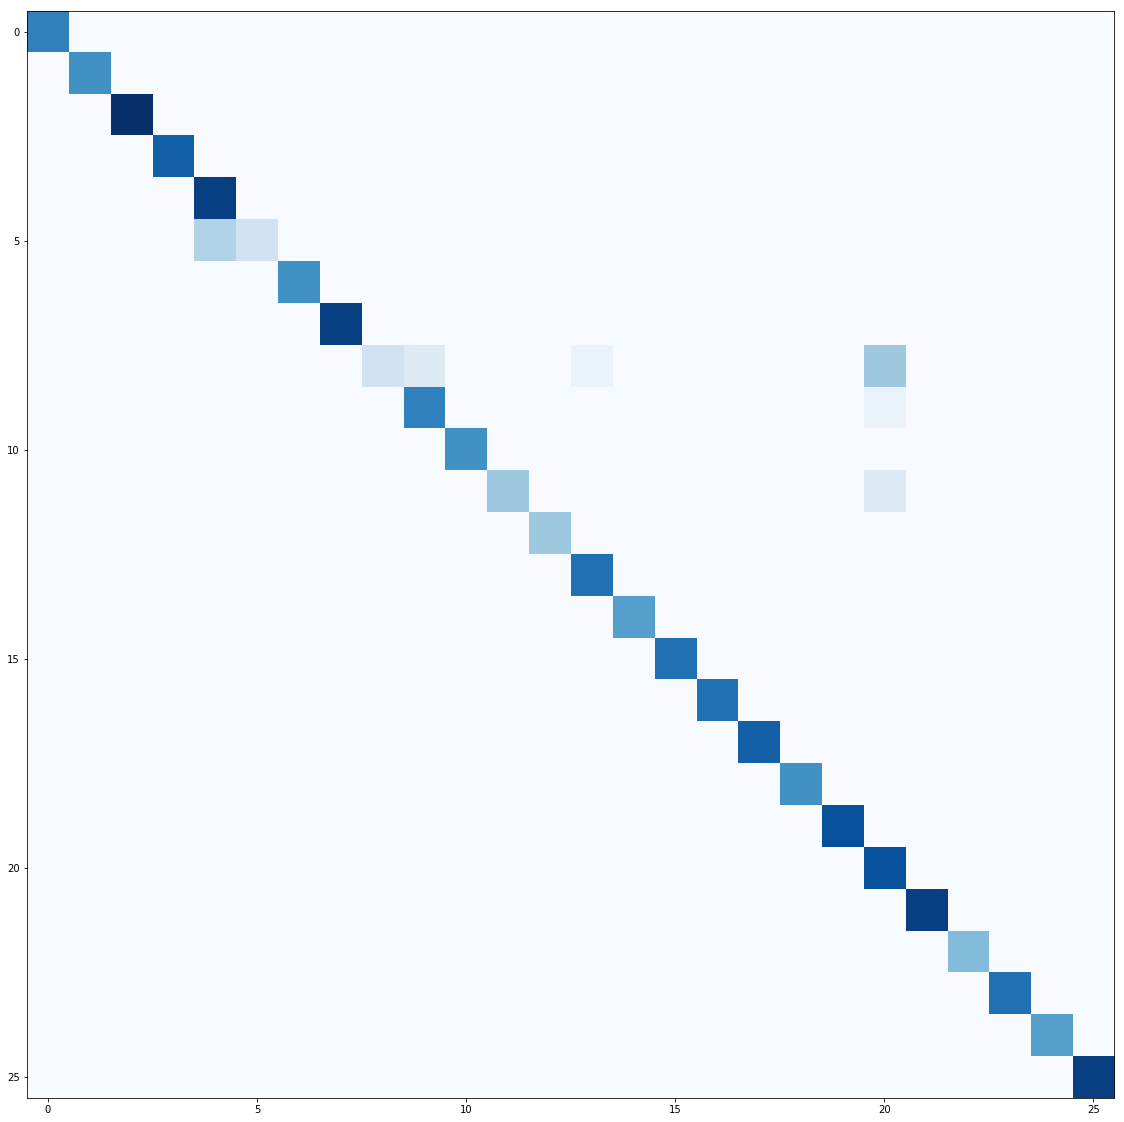

In [34]:
plt.figure(figsize=(20,20))
plt.imshow(cm, cmap="Blues")

In [35]:
from nltk.metrics import edit_distance
steps = edit_distance("STEP", "STOP")
print("The number of steps needed is: {0}".format(steps))

The number of steps needed is: 1


In [36]:
def compute_distance(prediction, word):
    return len(prediction) - sum(prediction[i] == word[i] for i in range(len(prediction)))

In [37]:
from operator import itemgetter
def improved_prediction(word, net, dictionary, shear=0.2):
    captcha = create_captcha(word, shear=shear)
    prediction = predict_captcha(captcha, net)
    prediction = prediction[:4]
    if prediction not in dictionary:
        distances = sorted([(word, compute_distance(prediction, word))
                            for word in dictionary],
                           key=itemgetter(1))
        best_word = distances[0]
        prediction = best_word[0]
    return word == prediction, word, prediction

In [38]:
num_correct = 0
num_incorrect = 0
for word in valid_words:
    correct, word, prediction = improved_prediction (word, net, valid_words, shear=0.2)
    if correct:
        num_correct += 1
    else:
        num_incorrect += 1
print("Number correct is {0}".format(num_correct))
print("Number incorrect is {0}".format(num_incorrect))

E:\Anaconda3\envs\DataMining\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Number correct is 391
Number incorrect is 5122
